In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
#from data import get_midi_data, MidiLoader
#from data import LabeledLoader, PianoTrackLoader
from data import PreprocessedLoader
from handcrafted import HandcraftedKeyModel
from lstmmodel import LSTMModel
import matplotlib.pyplot as plt
from torch.autograd import Variable
import gc
import numpy as np

batch_size = 1
#handcrafted = HandcraftedKeyModel().cuda()
#midi_data = get_midi_data(handcrafted)
#midi_loader = MidiLoader(midi_data, batch_size=batch_size, shuffle=False)
#unlabeled_loader = PianoTrackLoader('./dataset')
#midi_loader = LabeledLoader(unlabeled_loader, handcrafted)
midi_loader = PreprocessedLoader('./preprocessed')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


made it to song: 1000
made it to song: 2000
made it to song: 3000
made it to song: 4000
made it to song: 5000
made it to song: 6000
made it to song: 7000
made it to song: 8000
made it to song: 9000
made it to song: 10000


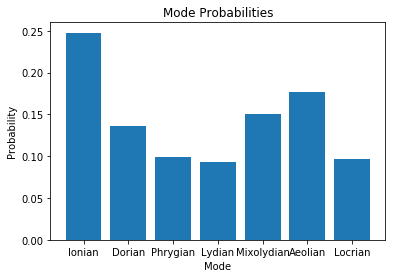

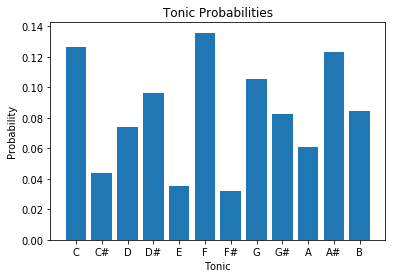

made it to song: 11000
made it to song: 12000
made it to song: 13000
made it to song: 14000
made it to song: 15000
made it to song: 16000
made it to song: 17000
made it to song: 18000
made it to song: 19000
made it to song: 20000


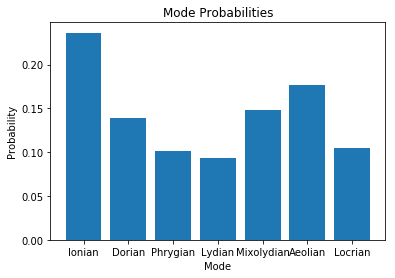

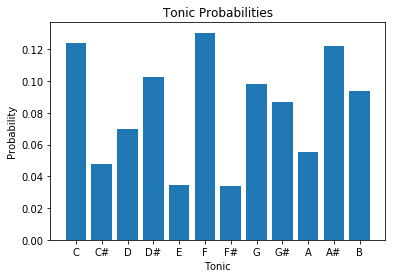

made it to song: 21000
made it to song: 22000
made it to song: 23000
made it to song: 24000
made it to song: 25000
made it to song: 26000
made it to song: 27000
made it to song: 28000
made it to song: 29000
made it to song: 30000


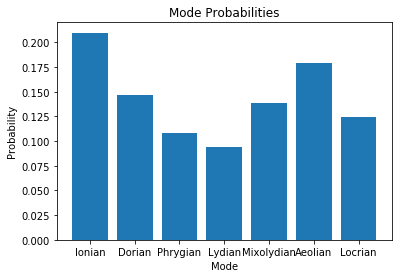

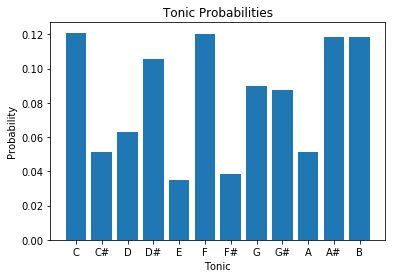

made it to song: 31000
made it to song: 32000
made it to song: 33000
made it to song: 34000
made it to song: 35000
made it to song: 36000
made it to song: 37000
made it to song: 38000
made it to song: 39000
made it to song: 40000


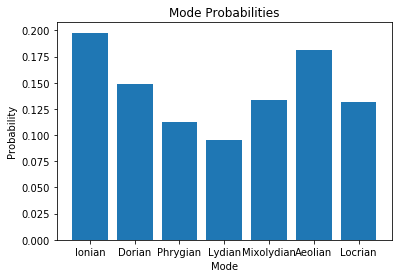

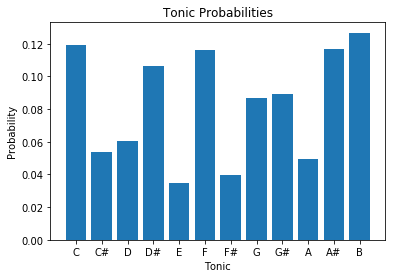

made it to song: 41000
made it to song: 42000
made it to song: 43000
made it to song: 44000
made it to song: 45000
made it to song: 46000
made it to song: 47000
made it to song: 48000
made it to song: 49000
made it to song: 50000


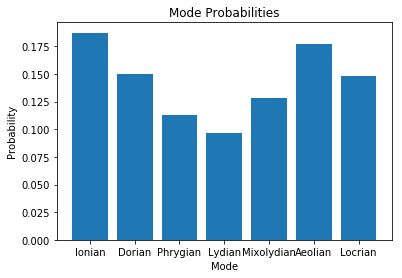

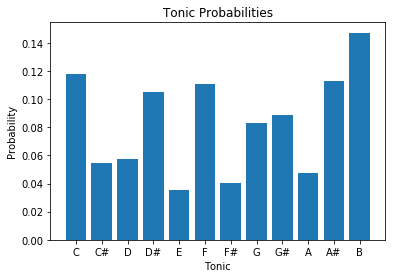

made it to song: 51000


IOError: [Errno 2] No such file or directory: './preprocessed/51153.data'

In [2]:
avg_labels = torch.FloatTensor(7, 12).cuda()
avg_labels.zero_()

modes = [
  "Ionian",
  "Dorian",
  "Phrygian",
  "Lydian",
  "Mixolydian",
  "Aeolian",
  "Locrian"
]

notes = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

for i, (data, labels) in enumerate(midi_loader):
    data = data.cuda()
    labels = labels.cuda()
    avg_labels += labels.mean(0).mean(1)
    if i % 1000 == 999:
        print "made it to song: {}".format(i + 1)
    if i % 10000 == 9999:
        plt.bar(np.arange(len(modes)), avg_labels.cpu().sum(1).view(len(modes)).numpy() / (i + 1.))
        plt.xlabel('Mode')
        plt.ylabel('Probability')
        plt.title('Mode Probabilities')
        plt.xticks(np.arange(len(modes)), modes)
        plt.show()
        plt.bar(np.arange(len(notes)), avg_labels.cpu().sum(0).view(len(notes)).numpy() / (i + 1.))
        plt.xlabel('Tonic')
        plt.ylabel('Probability')
        plt.title('Tonic Probabilities')
        plt.xticks(np.arange(len(notes)), notes)
        plt.show()

avg_labels /= len(midi_loader)

In [6]:
print avg_labels



Columns 0 to 9 
1.00000e-02 *
  3.6471  0.3444  1.7466  1.3759  0.9038  2.9511  0.2760  2.4580  0.8429  1.7538
  1.3056  0.7989  0.6637  1.8026  0.2575  1.6520  0.5255  1.0499  1.3941  0.4295
  1.8930  1.1748  0.2575  1.5715  0.3309  1.0276  0.7833  0.4339  1.8275  0.2219
  1.2338  0.2236  1.1744  0.4958  0.9332  1.0955  0.4142  1.6893  0.2939  0.9765
  1.7630  0.4941  1.1284  1.2021  0.4285  2.0972  0.2248  1.4226  1.0181  0.7365
  1.6197  1.5304  0.5819  3.3781  0.3798  1.8652  1.0650  1.0035  2.6248  0.3722
  0.2743  0.8966  0.1621  0.6800  0.2846  0.3706  0.7553  0.1925  0.8913  0.2380

Columns 10 to 11 
1.00000e-02 *
  1.8766  0.4763
  2.2748  2.8544
  1.2398  0.5558
  0.5916  0.5228
  2.0200  0.2619
  2.5853  0.6826
  0.7112  9.4312
[torch.cuda.FloatTensor of size 7x12 (GPU 0)]



In [7]:
net = LSTMModel(129, 50, 50, 2)
net.cuda()

LSTMModel (
  (dropout): Dropout (p = 0.5)
  (embedding): Embedding(129, 50)
  (rnn): LSTM(50, 50, num_layers=2, dropout=0.5)
  (linear): Linear (50 -> 84)
)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=.9)

In [ ]:
def reset_hidden(hidden):
    return (Variable(hidden[0].data), Variable(hidden[1].data))

for epoch in xrange(2):
    running_loss = 0.0
    hidden = net.init_hidden(batch_size)
    for i, data in enumerate(midi_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        hidden = reset_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = net(inputs, hidden)
        loss = criterion(output.view(-1, 7*12), labels.view(-1, 7*12))
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        gc.collect()
        if i % 2000 == 1999:
            print '[{}, {}] loss: {}'.format(epoch + 1, i + 1, running_loss / 2000)
            running_loss = 0.0
print 'finished training'